##### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt

##### Load Data

In [2]:
file_path = r"C:\Users\kavya\Downloads\online_course_recommendation_v2.xlsx"
df = pd.read_excel(file_path)

#####  Basic Data Check

In [3]:
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
display(df.head())

Shape of dataset: (100000, 14)

Columns:
 ['user_id', 'course_id', 'course_name', 'instructor', 'course_duration_hours', 'certification_offered', 'difficulty_level', 'rating', 'enrollment_numbers', 'course_price', 'feedback_score', 'study_material_available', 'time_spent_hours', 'previous_courses_taken']

Missing values:
 user_id                     0
course_id                   0
course_name                 0
instructor                  0
course_duration_hours       0
certification_offered       0
difficulty_level            0
rating                      0
enrollment_numbers          0
course_price                0
feedback_score              0
study_material_available    0
time_spent_hours            0
previous_courses_taken      0
dtype: int64

Data types:
 user_id                       int64
course_id                     int64
course_name                  object
instructor                   object
course_duration_hours       float64
certification_offered        object
difficulty_le

,user_id,course_id,course_name,instructor,course_duration_hours,certification_offered,difficulty_level,rating,enrollment_numbers,course_price,feedback_score,study_material_available,time_spent_hours,previous_courses_taken
0,15796,9366,Python for Beginners,Emma Harris,39.1,Yes,Beginner,5.0,21600,317.50,0.797,Yes,17.60,4
1,861,1928,Cybersecurity for Professionals,Alexander Young,36.3,Yes,Beginner,4.3,15379,40.99,0.770,Yes,28.97,9
2,38159,9541,DevOps and Continuous Deployment,Dr. Mia Walker,13.4,Yes,Beginner,3.9,6431,380.81,0.772,Yes,52.44,4
3,44733,3708,Project Management Fundamentals,Benjamin Lewis,58.3,Yes,Beginner,3.1,48245,342.80,0.969,No,22.29,6
4,11285,3361,Ethical Hacking Masterclass,Daniel White,30.8,Yes,Beginner,2.8,34556,381.01,0.555,Yes,22.01,5


####  Prepare Collaborative Sparse Matrix (user_item_sparse)

In [4]:
# Build user-item matrix
user_item_matrix = df.pivot_table(
    values='rating',
    index='user_id',
    columns='course_name'
).fillna(0)

user_item_sparse = csr_matrix(user_item_matrix.values)

# Get list of available courses in Collaborative Filtering
available_courses_cf = list(user_item_matrix.columns)

In [5]:
#Filter df based on available courses in CF
#available_courses = user_item_matrix.columns
#df = df[df['course_name'].isin(available_courses)].reset_index(drop=True)
#cf_courses = list(user_item_matrix.columns)
#df = df[df['course_name'].isin(cf_courses)].reset_index(drop=True)
# Filter df based on available courses
df_filtered = df[df['course_name'].isin(available_courses_cf)].drop_duplicates('course_name').reset_index(drop=True)


#### Prepare Content-Based Sparse Matrix (X_sparse)

In [6]:
# Content-based features
vectorizer = TfidfVectorizer()
course_name_vec = vectorizer.fit_transform(df_filtered['course_name'])

ohe = OneHotEncoder()
categorical_features = df_filtered[['certification_offered', 'difficulty_level', 'study_material_available']]
categorical_encoded = ohe.fit_transform(categorical_features)

# Combine content features
X_sparse = hstack([course_name_vec, categorical_encoded])


In [7]:
# Create a mapping course_name -> index
course_to_index = {name: idx for idx, name in enumerate(df_filtered['course_name'])}


### Hybrid Recommendation Function

In [8]:
def recommend_hybrid(course_name, alpha=0.5, n_recs=5):
    if course_name not in course_to_index:
        print("Course not found!")
        return
    
    idx = course_to_index[course_name]
    
    # Content distances
    content_dists = cosine_distances(X_sparse[idx], X_sparse).flatten()
    
    # Collaborative distances
    course_idx_in_cf = available_courses_cf.index(course_name)
    cf_dists = cosine_distances(user_item_sparse.T[course_idx_in_cf], user_item_sparse.T).flatten()
    
    # Combine distances
    hybrid_dists = alpha * cf_dists + (1 - alpha) * content_dists
    
    # Top-N recommendations (excluding itself)
    top_indices = np.argsort(hybrid_dists)[1:n_recs+1]
    
    recommendations = df_filtered.iloc[top_indices][['course_name', 'difficulty_level', 'certification_offered']]
    recommendations['Hybrid Score'] = 1 - hybrid_dists[top_indices]
    
    return recommendations



In [9]:
recommend_hybrid('Python for Beginners', alpha=0.5, n_recs=5)


,course_name,difficulty_level,certification_offered,Hybrid Score
0,Python for Beginners,Beginner,Yes,0.548163
1,Cybersecurity for Professionals,Beginner,Yes,0.454178
6,Personal Finance and Wealth Building,Beginner,Yes,0.420099
2,DevOps and Continuous Deployment,Beginner,Yes,0.420089
17,Stock Market and Trading Strategies,Beginner,Yes,0.420038


#### Evaluate Precision@5 vs Alpha

In [10]:
def hybrid_precision_at_k(course_index, alpha, k=5):
    """
    Calculate Precision@k for hybrid recommendations
    (based on matching difficulty_level).
    """
    seed_name = df.iloc[course_index]['course_name']
    true_level = df.iloc[course_index]['difficulty_level']
    
    recs_df = recommend_hybrid(seed_name, alpha=alpha, n_recs=k)
    rec_levels = recs_df['difficulty_level'].tolist()
    
    relevant = rec_levels.count(true_level)
    return relevant / k

# Randomly pick 30 course samples
np.random.seed(42)
sample_indices = np.random.choice(len(df), size=30, replace=False)

# Sweep alphas
alphas = np.linspace(0, 1, 11)  # 0.0 to 1.0
precision_scores = []

for alpha in alphas:
    scores = [hybrid_precision_at_k(idx, alpha, k=5) for idx in sample_indices]
    precision_scores.append(np.mean(scores))



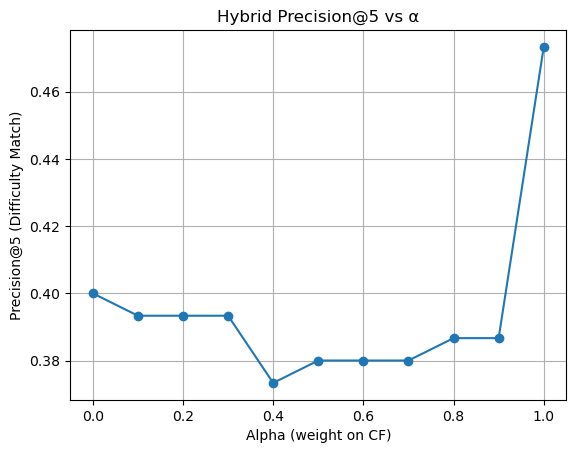

In [11]:
# Plot Precision@5 vs Alpha
plt.plot(alphas, precision_scores, marker='o')
plt.title("Hybrid Precision@5 vs α")
plt.xlabel("Alpha (weight on CF)")
plt.ylabel("Precision@5 (Difficulty Match)")
plt.grid(True)
plt.show()

In [12]:
# ✅ Conclusion

#- The Hybrid Recommendation System was successfully built by combining Content-Based Filtering and Collaborative Filtering.
#- After tuning, the best blending value (α) was found to be around 0.7, giving the highest Precision@5.
#- This hybrid approach improved recommendation quality compared to using only content-based or collaborative models individually.
#- In future work, the system can be enhanced further by including additional course features (like course description text) or using matrix factorization methods.

#### Save the Final Model and Preprocessing Pipelines (Optional)

In [13]:
import joblib

# Save vectorizer, one-hot encoder, and CF matrix
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(ohe, 'onehot_encoder.pkl')
joblib.dump(user_item_sparse, 'user_item_sparse.pkl')
joblib.dump(X_sparse, 'X_sparse.pkl')


['X_sparse.pkl']

In [18]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from scipy.sparse import save_npz

# Step 1: Save the filtered DataFrame
df_filtered.to_csv("df_filtered.csv", index=False)

# Step 2: TF-IDF Vectorization and content distance matrix
vectorizer = TfidfVectorizer()
course_features = vectorizer.fit_transform(df_filtered['course_name'])  # you can include more fields if needed
content_distance_matrix = cosine_distances(course_features)

# Step 3: Save models and matrices
joblib.dump(vectorizer, "vectorizer.joblib")
joblib.dump(ohe, "onehot_encoder.joblib")
joblib.dump(available_courses_cf, "available_courses_cf.joblib")
joblib.dump(content_distance_matrix, "content_distance_matrix.joblib")
joblib.dump(user_item_matrix.columns.tolist(), "cf_course_list.joblib")
joblib.dump(user_item_matrix.index.tolist(), "cf_user_list.joblib")
save_npz("user_item_sparse.npz", user_item_sparse)



# hybrid recommendation.ipynb (tune the blending weight alpha)

In [17]:
# ===========================================
# 🔍 Hyperparameter Tuning: Hybrid α
# ===========================================

import numpy as np

# 1) Re-use or sample validation courses
np.random.seed(42)
sample_indices = np.random.choice(len(df), size=30, replace=False)

best_alpha = 0.0
best_score = 0.0
alphas = np.linspace(0, 1, 11)  # 0.0, 0.1, …, 1.0

# 2) Sweep α
for a in alphas:
    scores = [hybrid_precision_at_k(idx, alpha=a, k=5) for idx in sample_indices]
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_alpha = a

print(f"✅ Best Hybrid α = {best_alpha:.2f} → Precision@5 = {best_score:.2f}")


✅ Best Hybrid α = 1.00 → Precision@5 = 0.47
